### Time to delivery classifier with Fully Connected NN

In [1]:
import config_FC as cfg
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import sys
sys.path.insert(1, "C:/sers/jaege/PycharmProjects/labour-katharina");
from labor_katharina import balance, semi_balance_cross_val, labels
import seaborn as sns
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_confusion_matrix, confusion_matrix
import random
from sklearn.model_selection import LeaveOneOut, KFold, cross_validate, cross_val_predict, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest
from datetime import datetime
import os
import shutil
import json
import pickle
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from uncertainties import ufloat
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, Dropout, Flatten
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
#load features
features = pd.read_pickle(cfg.features['path'])
features = features.sort_index()
features = features.reset_index()
features = features.drop(columns=['index'])
features = features.sample(frac=1)

In [3]:
#create labels
if cfg.label['type'] == 'time to delivery 1 week':
    y, features = labels.TTD_create(features, cfg.label['num_classes'])
elif cfg.label['type'] == 'time to delivery 2 week': 
    y, features = labels.TTD_create_2(features, cfg.label['num_classes'])

#get feature vector
X = features[cfg.features['names']]
features_meta = features.drop(columns=cfg.features['names'])
X = np.asarray(X) 

#print degree of unbalancing
[print('Class',c,':', len([i for i in y if i == c])/len(y)) for c in range(cfg.label['num_classes'])]    

Class 0 : 0.23871113222894236
Class 1 : 0.7612888677710576


[None, None]

In [4]:
report = []
conf_matrix = np.zeros((cfg.label['num_classes'],cfg.label['num_classes']))
hist = []

#print degree of unbalancing
[print('Class',c,':', len([i for i in y if i == c])/len(y)) for c in range(cfg.label['num_classes'])]    

#set up cross validation
skf = StratifiedKFold(cfg.validation['splits'])

for train_index, test_index in skf.split(X,y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    if cfg.validation['balancing'] == 'rus':
        rus = RandomUnderSampler()
        X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
        #c = svm.SVC()
    elif cfg.validation['balancing'] == 'smo':
        smote = SMOTE(k_neighbors = 3)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        #c = svm.SVC()
    elif cfg.validation['balancing'] == 'cweights':
        X_train_res, y_train_res = X_train, y_train


    #data normalization    
    scaler = MinMaxScaler()
    scaler.fit(X_train_res)
    X_train_res = scaler.transform(X_train_res)
    X_test = scaler.transform(X_test)
    
    ####TODO: gridsearch for parameter tuning######
        
    #building up FC network
    ########TODO###########
    classifier = Sequential()
    classifier.add(Dense(64, activation='relu', input_shape=X_train_res.shape[1:]))
    classifier.add(Dense(64, activation='relu'))
    classifier.add(Dense(cfg.label['num_classes'], activation='softmax'))


    classifier.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])


    #compute class weights and fit classifier
    if cfg.validation['balancing'] == 'cweights':
        #class_weights = {i:len(y_train)/(cfg.label['num_classes']*np.bincount(y_train)[i]) for i in range(cfg.label['num_classes'])}
        class_weights = {i:cfg.label['num_classes']*len(y_train_res)/np.bincount(y_train_res)[i]  for i in range(cfg.label['num_classes'])}
        history = classifier.fit(X_train_res, y_train_res, epochs=cfg.params['epochs'], validation_split=0.2, class_weight=class_weights, 
                            batch_size=cfg.params['batch_size'])
        
    else:
        history = classifier.fit(X_train_res, y_train_res, epochs=cfg.params['epochs'], validation_split=0.2,
                            batch_size=cfg.params['batch_size'])
        
    hist.append(history.history)

    #get predictions
    y_predict_prob = classifier.predict(X_test)
    y_predict = y_predict_prob.argmax(axis=-1)
    test_loss, test_acc = classifier.evaluate(X_test, y_test)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    
    
    report.append(classification_report(y_test, y_predict, output_dict=True))
    conf_matrix = np.add(conf_matrix, confusion_matrix(y_test, y_predict, normalize='true'))

Class 0 : 0.23871113222894236
Class 1 : 0.7612888677710576
Train on 79468 samples, validate on 19868 samples
Epoch 1/50
79468/79468 [==============================] - 4s 47us/step - loss: 2.7634 - accuracy: 0.4626 - val_loss: 2.7732 - val_accuracy: 0.5947
Epoch 2/50
79468/79468 [==============================] - 4s 45us/step - loss: 2.7595 - accuracy: 0.4840 - val_loss: 2.7637 - val_accuracy: 0.4649
Epoch 3/50
79468/79468 [==============================] - 4s 51us/step - loss: 2.7594 - accuracy: 0.4903 - val_loss: 2.7632 - val_accuracy: 0.4518
Epoch 4/50
79468/79468 [==============================] - 4s 52us/step - loss: 2.7588 - accuracy: 0.4915 - val_loss: 2.7658 - val_accuracy: 0.6044
Epoch 5/50
79468/79468 [==============================] - 4s 45us/step - loss: 2.7583 - accuracy: 0.5027 - val_loss: 2.7645 - val_accuracy: 0.5760
Epoch 6/50
79468/79468 [==============================] - 4s 45us/step - loss: 2.7585 - accuracy: 0.4955 - val_loss: 2.7637 - val_accuracy: 0.5382
Epoch 7/5

79469/79469 [==============================] - 5s 61us/step - loss: 2.7596 - accuracy: 0.5011 - val_loss: 2.7635 - val_accuracy: 0.4397
Epoch 5/50
79469/79469 [==============================] - 5s 61us/step - loss: 2.7594 - accuracy: 0.5048 - val_loss: 2.7814 - val_accuracy: 0.7376
Epoch 6/50
79469/79469 [==============================] - 4s 54us/step - loss: 2.7592 - accuracy: 0.5091 - val_loss: 2.7693 - val_accuracy: 0.3789
Epoch 7/50
79469/79469 [==============================] - 4s 55us/step - loss: 2.7591 - accuracy: 0.5011 - val_loss: 2.7620 - val_accuracy: 0.4733
Epoch 8/50
79469/79469 [==============================] - 4s 52us/step - loss: 2.7585 - accuracy: 0.5052 - val_loss: 2.7628 - val_accuracy: 0.4301
Epoch 9/50
79469/79469 [==============================] - 4s 50us/step - loss: 2.7584 - accuracy: 0.5052 - val_loss: 2.7649 - val_accuracy: 0.4173
Epoch 10/50
79469/79469 [==============================] - 4s 50us/step - loss: 2.7584 - accuracy: 0.5034 - val_loss: 2.7631 - va

79469/79469 [==============================] - 6s 73us/step - loss: 2.7588 - accuracy: 0.4990 - val_loss: 2.7643 - val_accuracy: 0.5885
Epoch 9/50
79469/79469 [==============================] - 6s 73us/step - loss: 2.7592 - accuracy: 0.5047 - val_loss: 2.7618 - val_accuracy: 0.4993
Epoch 10/50
79469/79469 [==============================] - 5s 66us/step - loss: 2.7589 - accuracy: 0.5032 - val_loss: 2.7639 - val_accuracy: 0.4299
Epoch 11/50
79469/79469 [==============================] - 5s 66us/step - loss: 2.7588 - accuracy: 0.5004 - val_loss: 2.7637 - val_accuracy: 0.5510
Epoch 12/50
79469/79469 [==============================] - 4s 51us/step - loss: 2.7586 - accuracy: 0.5003 - val_loss: 2.7624 - val_accuracy: 0.4596
Epoch 13/50
79469/79469 [==============================] - 4s 51us/step - loss: 2.7587 - accuracy: 0.4969 - val_loss: 2.7624 - val_accuracy: 0.4554
Epoch 14/50
79469/79469 [==============================] - 4s 49us/step - loss: 2.7584 - accuracy: 0.5007 - val_loss: 2.7660 

79469/79469 [==============================] - 2s 29us/step - loss: 2.7570 - accuracy: 0.5118 - val_loss: 2.7618 - val_accuracy: 0.4860
Epoch 13/50
79469/79469 [==============================] - 2s 29us/step - loss: 2.7563 - accuracy: 0.5130 - val_loss: 2.7618 - val_accuracy: 0.4778
Epoch 14/50
79469/79469 [==============================] - 3s 34us/step - loss: 2.7569 - accuracy: 0.5112 - val_loss: 2.7636 - val_accuracy: 0.4221
Epoch 15/50
79469/79469 [==============================] - 2s 25us/step - loss: 2.7568 - accuracy: 0.5079 - val_loss: 2.7637 - val_accuracy: 0.5939
Epoch 16/50
79469/79469 [==============================] - 2s 26us/step - loss: 2.7563 - accuracy: 0.5150 - val_loss: 2.7617 - val_accuracy: 0.4567
Epoch 17/50
79469/79469 [==============================] - 2s 25us/step - loss: 2.7565 - accuracy: 0.5134 - val_loss: 2.7621 - val_accuracy: 0.5340
Epoch 18/50
79469/79469 [==============================] - 2s 26us/step - loss: 2.7566 - accuracy: 0.5132 - val_loss: 2.7650

79469/79469 [==============================] - 2s 26us/step - loss: 2.7589 - accuracy: 0.5140 - val_loss: 2.7593 - val_accuracy: 0.5617
Epoch 17/50
79469/79469 [==============================] - 2s 25us/step - loss: 2.7585 - accuracy: 0.5194 - val_loss: 2.7648 - val_accuracy: 0.4129
Epoch 18/50
79469/79469 [==============================] - 2s 25us/step - loss: 2.7586 - accuracy: 0.5157 - val_loss: 2.7622 - val_accuracy: 0.6124
Epoch 19/50
79469/79469 [==============================] - 2s 27us/step - loss: 2.7587 - accuracy: 0.5169 - val_loss: 2.7594 - val_accuracy: 0.4742
Epoch 20/50
79469/79469 [==============================] - 2s 29us/step - loss: 2.7581 - accuracy: 0.5213 - val_loss: 2.7583 - val_accuracy: 0.5025
Epoch 21/50
79469/79469 [==============================] - 2s 25us/step - loss: 2.7584 - accuracy: 0.5197 - val_loss: 2.7589 - val_accuracy: 0.5189
Epoch 22/50
79469/79469 [==============================] - 2s 31us/step - loss: 2.7582 - accuracy: 0.5222 - val_loss: 2.7591

In [5]:
#print and store results
timestamp_path = './data/results/FC/' + datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
os.mkdir(timestamp_path)

#summarize report
acc = []
report_dict = {}
[acc.append(d['accuracy']) for d in report]
report_dict.update({'accuracy': {'mean': np.mean(acc), 'std': np.std(acc)}})#
for o in ('macro avg', 'weighted avg'):
    tmp = {}
    for i in ('precision', 'recall', 'f1-score'):
        tmp2 = []
        [tmp2.append([d[o][i] for d in report])]
        #print(o, i, tmp2)
        tmp.update({i: {'mean': np.mean(tmp2), 'std': np.std(tmp2)}})
    report_dict.update({o: tmp})

In [6]:
#print report and write to file
filename = timestamp_path + '/results.txt'
f = open(filename, 'w')#
f.write('-----------------------------------------------------------\n')
f.write('Accuracy:\t {}{}{}\n'.format(np.around(report_dict['accuracy']['mean'],2), '±', np.around(report_dict['accuracy']['std'],2)))
f.write('-----------------------------------------------------------\n')
f.write('\t\t macro avg \t\t weighted avg\n\n')#
f.write('F1-score:\t {}{}{} \t\t {}{}{}\n'.format(np.around(report_dict['macro avg']['f1-score']['mean'],2), '±', np.around(report_dict['macro avg']['f1-score']['std'],2) , 
      np.around(report_dict['weighted avg']['f1-score']['mean'],2),'±', np.around(report_dict['weighted avg']['f1-score']['std'],2), '\n'))##
f.write('precision:\t {}{}{} \t\t {}{}{}\n'.format(np.around(report_dict['macro avg']['precision']['mean'],2), '±',np.around(report_dict['macro avg']['precision']['std'],2) , 
      np.around(report_dict['weighted avg']['precision']['mean'],2), '±',np.around(report_dict['weighted avg']['precision']['std'],2)))##
f.write('recall:\t\t {}{}{} \t\t {}{}{}\n'.format(np.around(report_dict['macro avg']['recall']['mean'],2), '±', np.around(report_dict['macro avg']['recall']['std'],2),
                                                  np.around(report_dict['weighted avg']['recall']['mean'],2),'±', np.around(report_dict['weighted avg']['recall']['std'],2)))#
f.write('-----------------------------------------------------------')
f.close()#
#store report
with open(timestamp_path + '/results.pkl', 'wb') as handle:
        pickle.dump(report_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)#
#store config file
shutil.copyfile('./config_FC.py',timestamp_path + '/config_FC.py')
os.rename(timestamp_path + '/config_FC.py', timestamp_path + '/config_FC.txt')##
#print report
print('-----------------------------------------------------------')
print('Accuracy:\t', np.around(report_dict['accuracy']['mean'],2), '±', np.around(report_dict['accuracy']['std'],2))
print('-----------------------------------------------------------\n')
print('\t\t macro avg \t\t weighted avg\n')#
print('F1-score:\t', np.around(report_dict['macro avg']['f1-score']['mean'],2), '±', np.around(report_dict['macro avg']['f1-score']['std'],2) , '\t\t', 
      np.around(report_dict['weighted avg']['f1-score']['mean'],2),'±', np.around(report_dict['weighted avg']['f1-score']['std'],2), '\n')##
print('precision:\t', np.around(report_dict['macro avg']['precision']['mean'],2), '±',np.around(report_dict['macro avg']['precision']['std'],2) , '\t\t', 
      np.around(report_dict['weighted avg']['precision']['mean'],2), '±',np.around(report_dict['weighted avg']['precision']['std'],2))##
print('recall:\t\t', np.around(report_dict['macro avg']['recall']['mean'],2), '±', np.around(report_dict['macro avg']['recall']['std'],2),
      '\t\t', np.around(report_dict['weighted avg']['recall']['mean'],2),'±', np.around(report_dict['weighted avg']['recall']['std'],2))##
print('-----------------------------------------------------------')#

-----------------------------------------------------------
Accuracy:	 0.48 ± 0.03
-----------------------------------------------------------

		 macro avg 		 weighted avg

F1-score:	 0.46 ± 0.02 		 0.51 ± 0.03 

precision:	 0.53 ± 0.0 		 0.67 ± 0.0
recall:		 0.53 ± 0.0 		 0.48 ± 0.03
-----------------------------------------------------------


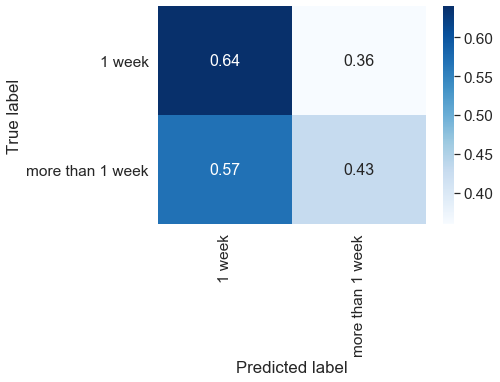

In [7]:
#create label names
label_names = []
label_names.append('1 week')
[label_names.append(str(c) + ' weeks') for c in range(2,cfg.label['num_classes'])]
if cfg.label['num_classes']==2:
    label_names.append('more than '+ str(cfg.label['num_classes']-1)+ ' week')
else:       
    label_names.append('more than '+ str(cfg.label['num_classes']-1)+ ' weeks')##
cf = np.around(np.divide(conf_matrix, cfg.validation['splits']),2)#
#store confusion_matrix
with open(timestamp_path + '/confusion_matrix.pkl', 'wb') as handle:
       pickle.dump(cf, handle, protocol=pickle.HIGHEST_PROTOCOL)#
#print and store image of confusion matrix
df_cm = pd.DataFrame(cf, label_names, label_names)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues) # font size
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.savefig(timestamp_path+'/confusion_matrix.pdf', bbox_inches='tight')
plt.savefig(timestamp_path+'/confusion_matrix.eps', bbox_inches='tight')
plt.savefig(timestamp_path+'/confusion_matrix.svg', bbox_inches='tight')
plt.show()

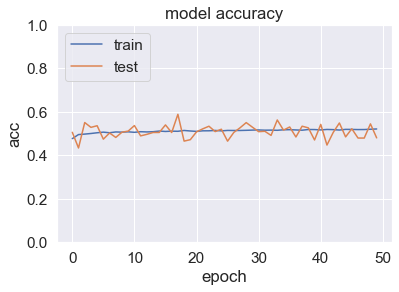

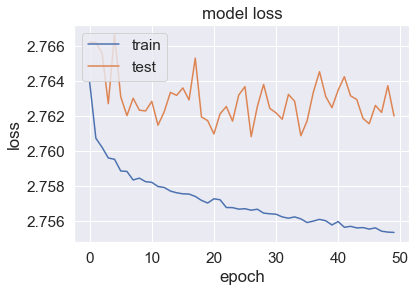

In [8]:
val_loss = hist[0]['val_loss']
val_acc = hist[0]['val_accuracy']
loss = hist[0]['loss']
acc = hist[0]['accuracy']#
hist_en = iter(hist)
next(hist_en)
for _,i in enumerate(hist_en):
    val_loss = [g+h for g,h in zip(i['val_loss'], val_loss)]
    val_acc = [g+h for g,h in zip(i['val_accuracy'], val_acc)]
    loss = [g+h for g,h in zip(i['loss'], loss)]
    acc = [g+h for g,h in zip(i['accuracy'], acc)]#
val_loss = [g/cfg.validation['splits'] for g in val_loss]
val_acc = [g/cfg.validation['splits'] for g in val_acc]
loss = [g/cfg.validation['splits'] for g in loss]
acc = [g/cfg.validation['splits'] for g in acc]#
hist_dict = {'val_loss': val_loss, 'val_accuracy': val_acc, 'loss': loss, 'accuracy': acc}#
#store report
with open(timestamp_path + '/history.pkl', 'wb') as handle:
        pickle.dump(hist_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xticks(range(0, cfg.epochs))
plt.ylim([0,1])
plt.savefig(timestamp_path+'/model_accuracy.pdf', bbox_inches='tight')
plt.savefig(timestamp_path+'/model_accuracy.eps', bbox_inches='tight')
plt.savefig(timestamp_path+'/model_accuracy.svg', bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xticks(range(0, cfg.epochs))
#plt.ylim([0, 1])
plt.savefig(timestamp_path+'/model_loss.pdf', bbox_inches='tight')
plt.savefig(timestamp_path+'/model_loss.eps', bbox_inches='tight')
plt.savefig(timestamp_path+'/model_loss.svg', bbox_inches='tight')
plt.show()